# Scatter: Salinity and Nitrate

We have to prove first that salinity is a good tracer for nitrate, which affects the bloom of phytoplankton. We know that usually, the salinity and nitrate both increase with depth, and the fresh water from Fraser River is low-nitrate.

开始处理数据...
正在从以下日期抽取数据: [(2010, 1), (2014, 5), (2016, 10), (2012, 12), (2007, 8), (2019, 12), (2007, 3), (2016, 7), (2013, 1), (2018, 6)]
总共抽取样本点: 20000
图表已保存至: salinity_nitrate_relationship.svg


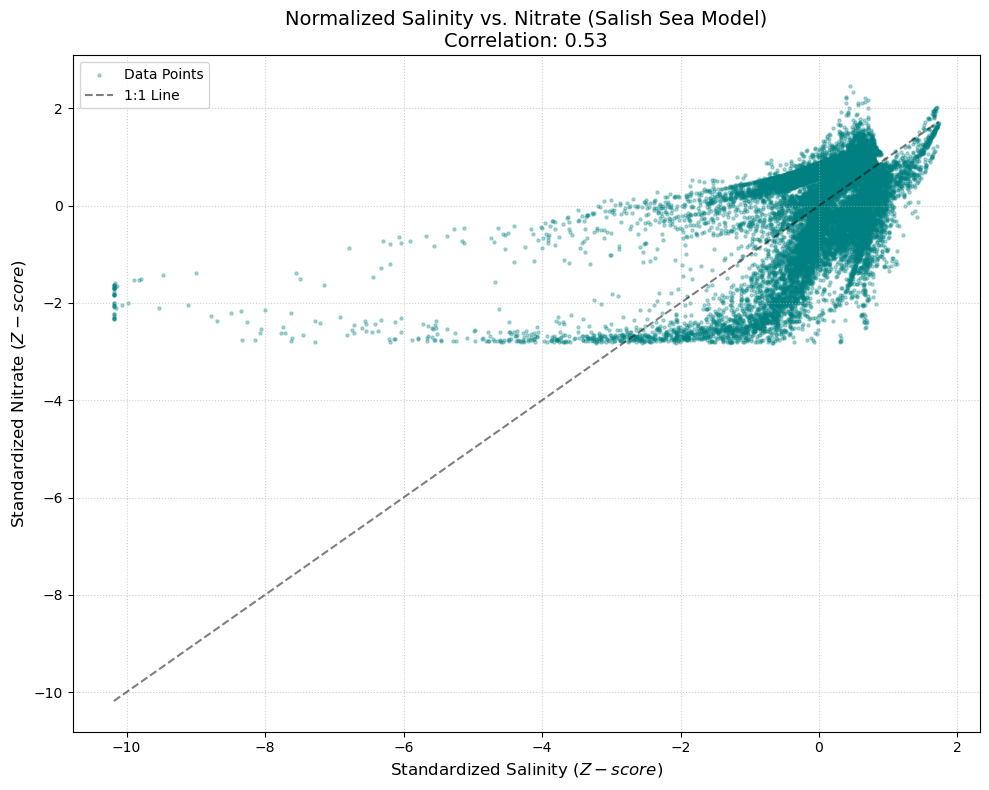

In [2]:
# Salinity vs Nitrate

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import calendar
import random

# ================= 配置区域 =================
# 基础路径 
BASE_DIR = '/results2/SalishSea/month-avg.201905/'

# 变量名定义
VAR_SALINITY = 'vosaline'
VAR_NITRATE = 'nitrate'

# 采样配置
START_YEAR = 2007
END_YEAR = 2022
SAMPLES_PER_MONTH = 2000  # 每个月随机抽取的点数
MONTHS_TO_SAMPLE = 10     # 总共随机抽取多少个月份的数据来做分析

# 输出图片名称
OUTPUT_PLOT = 'salinity_nitrate_relationship.svg'
# ===========================================

def get_file_path(year, month, file_type):
    """
    根据年份和月份构建文件名。
    file_type: 'grid_T' (盐度) 或 'ptrc_T' (生物化学)
    """
    # 获取该月最后一天，例如 28, 30, 31
    _, last_day = calendar.monthrange(year, month)
    
    # 格式化日期字符串 YYYYMMDD
    start_date = f"{year}{month:02d}01"
    end_date = f"{year}{month:02d}{last_day}"
    
    # 构建文件名
    filename = f"SalishSeaCast_1m_{file_type}_{start_date}_{end_date}.nc"
    return os.path.join(BASE_DIR, filename)

def get_standardized_data():
    all_salt = []
    all_nitrate = []
    
    # 随机选择年份和月份组合
    available_dates = []
    for y in range(START_YEAR, END_YEAR + 1):
        for m in range(1, 13):
            available_dates.append((y, m))
    
    # 随机抽取 X 个月份进行分析
    selected_dates = random.sample(available_dates, min(MONTHS_TO_SAMPLE, len(available_dates)))
    print(f"正在从以下日期抽取数据: {selected_dates}")

    for year, month in selected_dates:
        f_salt = get_file_path(year, month, 'grid_T')
        f_nitrate = get_file_path(year, month, 'ptrc_T')
        
        # 检查文件是否存在
        if not os.path.exists(f_salt) or not os.path.exists(f_nitrate):
            print(f"跳过 {year}-{month}: 文件未找到")
            continue
            
        try:
            # 打开数据集
            # chunks参数用于延迟加载，防止爆内存
            ds_s = xr.open_dataset(f_salt, chunks={}) 
            ds_n = xr.open_dataset(f_nitrate, chunks={})
            
            # 提取数据 (展平为一维数组)
            # 注意：SalishSeaCast通常0或者是NaN代表陆地，需要过滤
            # 这里我们先读取数据到内存
            salt_data = ds_s[VAR_SALINITY].isel(time=0).values.flatten()
            nitrate_data = ds_n[VAR_NITRATE].isel(time=0).values.flatten()
            
            # 创建掩码：过滤掉陆地 (盐度为0) 和 无效值 (NaN)
            # 同时也过滤掉氮含量异常的数据（如果有）
            valid_mask = (salt_data > 0) & (~np.isnan(salt_data)) & (~np.isnan(nitrate_data))
            
            salt_valid = salt_data[valid_mask]
            nitrate_valid = nitrate_data[valid_mask]
            
            # 如果有效数据点太少，跳过
            if len(salt_valid) < SAMPLES_PER_MONTH:
                continue
                
            # 随机抽样索引
            indices = np.random.choice(len(salt_valid), SAMPLES_PER_MONTH, replace=False)
            
            all_salt.append(salt_valid[indices])
            all_nitrate.append(nitrate_valid[indices])
            
            ds_s.close()
            ds_n.close()
            
        except Exception as e:
            print(f"处理 {year}-{month} 时出错: {e}")

    # 将所有月份的数据合并
    final_salt = np.concatenate(all_salt)
    final_nitrate = np.concatenate(all_nitrate)
    
    # 标准化 (Standardization / Z-score Normalization)
    # 公式: (X - mean) / std
    salt_norm = (final_salt - np.mean(final_salt)) / np.std(final_salt)
    nitrate_norm = (final_nitrate - np.mean(final_nitrate)) / np.std(final_nitrate)
    
    return salt_norm, nitrate_norm

def plot_relationship(salt, nitrate):
    plt.figure(figsize=(10, 8))
    
    # 绘制散点图
    # alpha=0.3 让重叠的点显示出密度感
    plt.scatter(salt, nitrate, s=5, alpha=0.3, c='teal', label='Data Points')
    
    # 绘制 y=x 参考线 (如果完全正相关) 和 y=-x (如果完全负相关)
    # 盐度和营养盐通常是负相关，或者是复杂的混合曲线
    x_vals = np.linspace(min(salt), max(salt), 100)
    plt.plot(x_vals, x_vals, 'k--', alpha=0.5, label='1:1 Line')
    
    # 计算简单的线性回归相关系数
    corr = np.corrcoef(salt, nitrate)[0, 1]
    
    plt.title(f'Normalized Salinity vs. Nitrate (Salish Sea Model)\nCorrelation: {corr:.2f}', fontsize=14)
    plt.xlabel('Standardized Salinity ($Z-score$)', fontsize=12)
    plt.ylabel('Standardized Nitrate ($Z-score$)', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PLOT, dpi=300)
    print(f"图表已保存至: {OUTPUT_PLOT}")

if __name__ == "__main__":
    print("开始处理数据...")
    s_norm, n_norm = get_standardized_data()
    
    if len(s_norm) > 0:
        print(f"总共抽取样本点: {len(s_norm)}")
        plot_relationship(s_norm, n_norm)
    else:
        print("未提取到有效数据，请检查路径或文件。")

正在分析日期: [(2018, 4), (2020, 12), (2015, 4), (2008, 9), (2011, 7), (2016, 8), (2008, 6), (2013, 9), (2014, 12), (2021, 7)]
图表已保存至: salinity_nitrate_depth_separated.svg


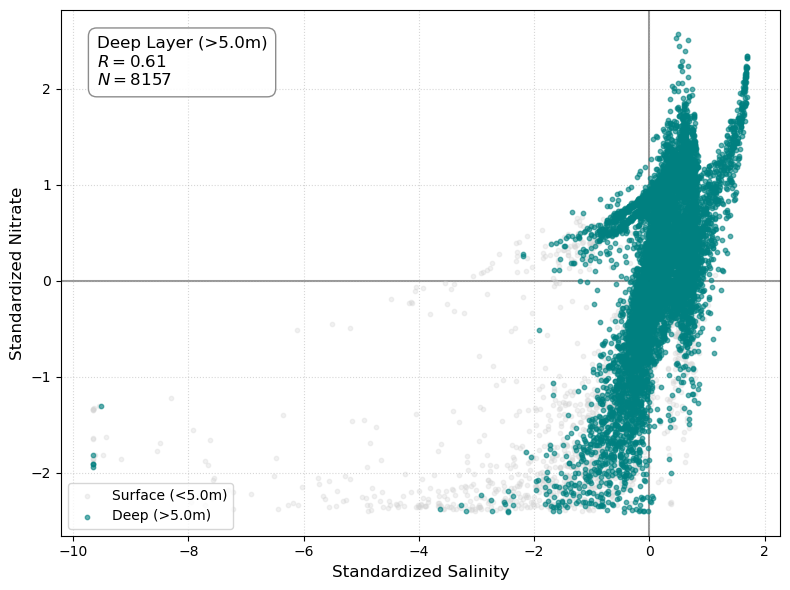

In [1]:
# Salinity vs Nitrate Depth Marked

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import calendar
import random

# ================= 配置区域 =================
BASE_DIR = '/results2/SalishSea/month-avg.201905/'

# 变量名
VAR_SALINITY = 'vosaline'
VAR_NITRATE = 'nitrate'
VAR_DEPTH = 'depth' # 深度变量名

# 采样配置
START_YEAR = 2007
END_YEAR = 2022
SAMPLES_PER_MONTH = 1000 
MONTHS_TO_SAMPLE = 10     

# 深度阈值 (米)
# 30米以下通常被认为是深层水，受光照和生物消耗影响较小
DEPTH_THRESHOLD = 5.0 

OUTPUT_PLOT = 'salinity_nitrate_depth_separated.svg'
# ===========================================

def get_file_path(year, month, file_type):
    _, last_day = calendar.monthrange(year, month)
    start_date = f"{year}{month:02d}01"
    end_date = f"{year}{month:02d}{last_day}"
    filename = f"SalishSeaCast_1m_{file_type}_{start_date}_{end_date}.nc"
    return os.path.join(BASE_DIR, filename)

def get_data_with_depth():
    all_salt = []
    all_nitrate = []
    all_depth = [] # 新增：存储深度数据
    
    available_dates = []
    for y in range(START_YEAR, END_YEAR + 1):
        for m in range(1, 13):
            available_dates.append((y, m))
    
    selected_dates = random.sample(available_dates, min(MONTHS_TO_SAMPLE, len(available_dates)))
    print(f"正在分析日期: {selected_dates}")

    for year, month in selected_dates:
        f_salt = get_file_path(year, month, 'grid_T')
        f_nitrate = get_file_path(year, month, 'ptrc_T')
        
        if not os.path.exists(f_salt) or not os.path.exists(f_nitrate):
            continue
            
        try:
            ds_s = xr.open_dataset(f_salt, chunks={}) 
            ds_n = xr.open_dataset(f_nitrate, chunks={})
            
            # 1. 提取单个月份的数据 (Time=0)
            # 此时数据的形状应该是 (Depth, Y, X)
            salt_3d = ds_s[VAR_SALINITY].isel(time=0)
            nitrate_3d = ds_n[VAR_NITRATE].isel(time=0)
            
            # 2. 处理深度
            # deptht 通常是 1D 数组 (40,)，我们需要把它扩展成 (40, 898, 398)
            # 这样每个数据点才能对应一个深度值
            depth_3d = ds_s[VAR_DEPTH].broadcast_like(salt_3d)

            # 3. 展平 (Flatten)
            s_flat = salt_3d.values.flatten()
            n_flat = nitrate_3d.values.flatten()
            d_flat = depth_3d.values.flatten()
            
            # 4. 掩码过滤 (去陆地 NaN 和 0)
            valid_mask = (s_flat > 0) & (~np.isnan(s_flat)) & (~np.isnan(n_flat))
            
            s_valid = s_flat[valid_mask]
            n_valid = n_flat[valid_mask]
            d_valid = d_flat[valid_mask]
            
            if len(s_valid) < SAMPLES_PER_MONTH:
                continue
                
            # 随机抽样
            indices = np.random.choice(len(s_valid), SAMPLES_PER_MONTH, replace=False)
            
            all_salt.append(s_valid[indices])
            all_nitrate.append(n_valid[indices])
            all_depth.append(d_valid[indices])
            
            ds_s.close()
            ds_n.close()
            
        except Exception as e:
            print(f"Error processing {year}-{month}: {e}")

    # 合并数组
    final_salt = np.concatenate(all_salt)
    final_nitrate = np.concatenate(all_nitrate)
    final_depth = np.concatenate(all_depth)
    
    # 全局标准化 (使用整体的均值和方差，保持相对物理意义)
    salt_norm = (final_salt - np.mean(final_salt)) / np.std(final_salt)
    nitrate_norm = (final_nitrate - np.mean(final_nitrate)) / np.std(final_nitrate)
    
    return salt_norm, nitrate_norm, final_depth

def plot_separated(salt, nitrate, depth):
    
    # 创建画布 (稍微调整大小以适应论文排版，通常正方形或4:3较好)
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # 掩码
    shallow_mask = depth <= DEPTH_THRESHOLD
    deep_mask = depth > DEPTH_THRESHOLD
    
    # === 绘制基准线 ===
    ax.axhline(0, color='black', linewidth=1.5, linestyle='-', alpha=0.4, zorder=1)
    ax.axvline(0, color='black', linewidth=1.5, linestyle='-', alpha=0.4, zorder=1)
    
    # 1. 表层 (Surface < 5m) - 灰色背景
    ax.scatter(salt[shallow_mask], nitrate[shallow_mask], 
               s=10, c='lightgray', alpha=0.3, label=f'Surface (<{DEPTH_THRESHOLD}m)', zorder=2)
    
    # 2. 深层 (Deep > 5m) - 核心分析对象
    ax.scatter(salt[deep_mask], nitrate[deep_mask], 
               s=10, c='teal', alpha=0.6, label=f'Deep (>{DEPTH_THRESHOLD}m)', zorder=2)
    
    # === 关键修改：把统计信息写在图里面 ===
    if np.sum(deep_mask) > 0:
        # 计算相关系数
        r_val = np.corrcoef(salt[deep_mask], nitrate[deep_mask])[0, 1]
        n_count = np.sum(deep_mask)
        
        # 构造显示的文本 (使用LaTeX格式让数学符号更漂亮)
        stats_text = (f'Deep Layer (>{DEPTH_THRESHOLD}m)\n'
                      f'$R = {r_val:.2f}$\n'
                      f'$N = {n_count}$')
        
        # 在左上角添加文本框
        # transform=ax.transAxes 意味着使用坐标轴的相对坐标 (0,0)左下 - (1,1)右上
        # (0.05, 0.95) 表示左边距 5%，上边距 5% 的位置
        ax.text(0.05, 0.95, stats_text,
                transform=ax.transAxes,
                fontsize=12,
                verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # 移除原本的 plt.title
    # 设置坐标轴标签
    ax.set_xlabel('Standardized Salinity', fontsize=12)
    ax.set_ylabel('Standardized Nitrate', fontsize=12)
    
    # 图例放在左下角，避免和统计文字打架
    ax.legend(loc='lower left', frameon=True)
    
    ax.grid(True, linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PLOT, dpi=300) # 300 dpi 是论文标准
    print(f"图表已保存至: {OUTPUT_PLOT}")

if __name__ == "__main__":
    s_norm, n_norm, depths = get_data_with_depth()
    
    if len(s_norm) > 0:
        plot_separated(s_norm, n_norm, depths)
    else:
        print("无有效数据。")

The following section can be put in the Methods part to explain why we use salinity as a good tracer of nitrate! (I hope it's a good tracer anyway.)

To isolate the physical mechanisms driving nutrient supply from biological consumption, we examined the relationship between salinity and nitrate. A robust positive correlation was found in subsurface waters (>5 m), where biological drawdown is minimal (Fig. ). Consequently, we utilize salinity as a conservative tracer in the subsequent PCA analysis to characterize wind-driven nutrient transport.

Or we can put it in the results part? 

Relationship between Salinity and Nitrate Before analyzing wind effects, we first established the coupling between physical and biogeochemical fields. Fig. shows the scatter plot of standardized salinity versus nitrate. While surface waters (<5 m) exhibit decoupling due to biological uptake, subsurface waters (>5 m) show a strong linear correlation. This suggests that nutrient variability in the deep layer is primarily physically controlled, validating the use of salinity patterns to infer nutrient supply mechanisms.

It seems that there is something wrong with the standardization? We will check it again.

Z-score standardization!

正在分析日期: [(2007, 7), (2013, 7), (2017, 7), (2013, 9), (2014, 1), (2008, 3), (2012, 7), (2016, 4), (2008, 4), (2013, 12)]
目标深度范围: 5.0m < depth < 100.0m
图表已保存至: salinity_nitrate_intermediate_5m_200m.svg


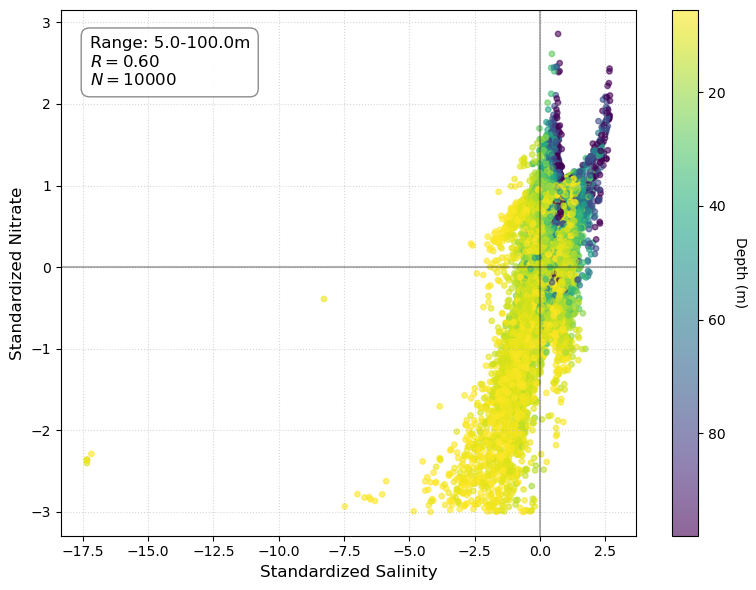

In [12]:
# Salinity vs Nitrate (Intermediate Layer: 5m - 200m)

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import calendar
import random

# ================= 配置区域 =================
BASE_DIR = '/results2/SalishSea/month-avg.201905/'

# 变量名
VAR_SALINITY = 'vosaline'
VAR_NITRATE = 'nitrate'
VAR_DEPTH = 'depth' 

# 采样配置
START_YEAR = 2007
END_YEAR = 2022
SAMPLES_PER_MONTH = 1000 
MONTHS_TO_SAMPLE = 10     

# === 核心修改：深度区间配置 ===
DEPTH_MIN = 5.0    # 避开表层
DEPTH_MAX = 100.0  # 避开底层深水团

OUTPUT_PLOT = 'salinity_nitrate_intermediate_5m_200m.svg'
# ===========================================

def get_file_path(year, month, file_type):
    _, last_day = calendar.monthrange(year, month)
    start_date = f"{year}{month:02d}01"
    end_date = f"{year}{month:02d}{last_day}"
    filename = f"SalishSeaCast_1m_{file_type}_{start_date}_{end_date}.nc"
    return os.path.join(BASE_DIR, filename)

def get_filtered_data():
    all_salt = []
    all_nitrate = []
    all_depth = []
    
    available_dates = []
    for y in range(START_YEAR, END_YEAR + 1):
        for m in range(1, 13):
            available_dates.append((y, m))
    
    selected_dates = random.sample(available_dates, min(MONTHS_TO_SAMPLE, len(available_dates)))
    print(f"正在分析日期: {selected_dates}")
    print(f"目标深度范围: {DEPTH_MIN}m < depth < {DEPTH_MAX}m")

    for year, month in selected_dates:
        f_salt = get_file_path(year, month, 'grid_T')
        f_nitrate = get_file_path(year, month, 'ptrc_T')
        
        if not os.path.exists(f_salt) or not os.path.exists(f_nitrate):
            continue
            
        try:
            ds_s = xr.open_dataset(f_salt, chunks={}) 
            ds_n = xr.open_dataset(f_nitrate, chunks={})
            
            # 1. 提取数据
            salt_3d = ds_s[VAR_SALINITY].isel(time=0)
            nitrate_3d = ds_n[VAR_NITRATE].isel(time=0)
            
            # 2. 处理深度广播
            depth_3d = ds_s[VAR_DEPTH].broadcast_like(salt_3d)

            # 3. 展平
            s_flat = salt_3d.values.flatten()
            n_flat = nitrate_3d.values.flatten()
            d_flat = depth_3d.values.flatten()
            
            # === 核心修改：在采样前进行深度区间过滤 ===
            valid_mask = (
                (s_flat > 0) & 
                (~np.isnan(s_flat)) & 
                (~np.isnan(n_flat)) &
                (d_flat > DEPTH_MIN) &   # 大于 5m
                (d_flat < DEPTH_MAX)     # 小于 200m
            )
            
            s_valid = s_flat[valid_mask]
            n_valid = n_flat[valid_mask]
            d_valid = d_flat[valid_mask]
            
            # 检查是否有足够数据
            if len(s_valid) < SAMPLES_PER_MONTH:
                print(f"Warning: {year}-{month} 只有 {len(s_valid)} 个有效点，全部使用。")
                indices = np.arange(len(s_valid))
            else:
                indices = np.random.choice(len(s_valid), SAMPLES_PER_MONTH, replace=False)
            
            all_salt.append(s_valid[indices])
            all_nitrate.append(n_valid[indices])
            all_depth.append(d_valid[indices])
            
            ds_s.close()
            ds_n.close()
            
        except Exception as e:
            print(f"Error processing {year}-{month}: {e}")

    if not all_salt:
        return np.array([]), np.array([]), np.array([])

    # 合并数组
    final_salt = np.concatenate(all_salt)
    final_nitrate = np.concatenate(all_nitrate)
    final_depth = np.concatenate(all_depth)
    
    # 标准化 (这里的均值和方差是专门针对 5-200m 这一层的)
    salt_norm = (final_salt - np.mean(final_salt)) / np.std(final_salt)
    nitrate_norm = (final_nitrate - np.mean(final_nitrate)) / np.std(final_nitrate)
    
    return salt_norm, nitrate_norm, final_depth

def plot_intermediate_layer(salt, nitrate, depth):
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # 绘制基准线
    ax.axhline(0, color='black', linewidth=1.5, linestyle='-', alpha=0.3)
    ax.axvline(0, color='black', linewidth=1.5, linestyle='-', alpha=0.3)
    
    # === 修改点 1: 使用 viridis_r (反向颜色) ===
    # 这样数值小(浅)的地方是黄色，数值大(深)的地方是紫色，符合光照物理直觉
    sc = ax.scatter(salt, nitrate, c=depth, s=15, alpha=0.6, cmap='viridis_r', label='Data Points')
    
    # === 修改点 2: 翻转 Colorbar ===
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Depth (m)', rotation=270, labelpad=15)
    
    # 核心代码：翻转 Colorbar 的 Y 轴
    # 效果：顶部是 5m (Min)，底部是 200m (Max)
    cbar.ax.invert_yaxis()
    
    # === 统计信息 ===
    r_val = np.corrcoef(salt, nitrate)[0, 1]
    n_count = len(salt)
    
    stats_text = (f'Range: {DEPTH_MIN}-{DEPTH_MAX}m\n'
                  f'$R = {r_val:.2f}$\n'
                  f'$N = {n_count}$')
    
    ax.text(0.05, 0.95, stats_text,
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    ax.set_xlabel('Standardized Salinity', fontsize=12)
    ax.set_ylabel('Standardized Nitrate', fontsize=12)
    # ax.set_title(f'Salinity vs Nitrate ({DEPTH_MIN}m - {DEPTH_MAX}m)', fontsize=14)
    
    ax.grid(True, linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PLOT, dpi=300)
    print(f"图表已保存至: {OUTPUT_PLOT}")

if __name__ == "__main__":
    s_norm, n_norm, depths = get_filtered_data()
    
    if len(s_norm) > 0:
        plot_intermediate_layer(s_norm, n_norm, depths)
    else:
        print("未找到指定深度范围内的有效数据。")

## Methods

While nitrate is a primary limiting nutrient for phytoplankton growth in the Salish Sea, its instantaneous concentration is simultaneously regulated by physical transport (supply) and biological uptake (consumption). Consequently, low observed nitrate levels may reflect either nutrient-poor water masses or post-bloom biological depletion, confounding the analysis of physical supply mechanisms. To address this, we evaluated salinity as a conservative proxy for nitrate availability, premised on the strong physical coupling between high-salinity deep water and nutrient content in this estuarine system.

To validate this relationship, we conducted a correlation analysis using model hindcast data from 2007 to 2022. We focused on the intermediate water column (5–200 m) to exclude the immediate surface layer—where biological variability is highest—and the deep stagnant basins. Both salinity and nitrate data were standardized using Z-scores (global normalization) to account for their distinct physical units and dynamic ranges. This standardization allows for a direct comparison of their spatial-temporal variability and confirms the utility of salinity as a robust indicator of nutrient supply potential.

## Results

As hypothesized, a strong linear correlation (R=0.60) was observed between standardized salinity and nitrate in the intermediate layer. This confirms that physical mixing of saline deep water is the dominant driver of nutrient supply, justifying the use of salinity to trace nutrient injection events.